In [55]:
# Initial imports
import os
import requests
import pandas as pd
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import streamlit as st
import hvplot.pandas
import plotly.express as px
%matplotlib inline

In [56]:
# Load .env enviroment variables
load_dotenv()

True

In [57]:
csv_name = input("enter csv name to load portfolio data")
filepath = Path(csv_name+'.csv')  

In [58]:
# read in portfolio.csv format date,ticker,shares,share_price, clean data, set date as index,
portfolio_df = pd.read_csv(Path(csv_name+'.csv'), index_col=0, parse_dates=True, infer_datetime_format=True)
display(portfolio_df)

,symbol,no_of_shares,share_price
order_date,,,
2022-03-15,AAPL,320,155.09
2022-01-24,MSFT,170,296.37
2022-03-14,TSLA,200,255.46
2020-03-16,TSLA,73,29.67
2020-03-16,AAPL,83,60.50
2020-03-16,MSFT,37,135.42
2020-03-16,AMZN,59,84.46


In [78]:
#   for some reason this always has to be re run to show the right names. no code needs to be changed. just run cell again. i want this to show number of shares
#   add profit/loss column, (takes the number of shares * purchase share_price) - current prices
portfolio_df['order_total'] = portfolio_df['no_of_shares']*portfolio_df['share_price']

display(portfolio_df)

plot = px.pie(
    portfolio_df, 
    values=portfolio_df.keys()[2],
    names=portfolio_df.keys()[1],
    color_discrete_sequence=px.colors.sequential.RdBu,
    title= 'Portfolio initial investment Prior to Tax Harvest'
    )
plot.show()

,order_date,symbol,no_of_shares,share_price,order_total
0,2022-03-15,AAPL,320,155.09,49628.80
1,2022-01-24,MSFT,170,296.37,50382.90
2,2022-03-14,TSLA,200,255.46,51092.00
3,2020-03-16,TSLA,73,29.67,2165.91
4,2020-03-16,AAPL,83,60.50,5021.50
5,2020-03-16,MSFT,37,135.42,5010.54
6,2020-03-16,AMZN,59,84.46,4983.14


In [60]:
# get current prices. use api to get current price

API_KEY = os.getenv('ALPACA_API_KEY')

API_SECRET_KEY = os.getenv('ALPACA_SECRET_KEY')

type(API_KEY)

# Create the Alpaca API object
alpaca = tradeapi.REST(
    API_KEY,
    API_SECRET_KEY,
    api_version='v2'
)

# Format current date as ISO format NEED TO AUTO GRAB TODAY'S DATE
api_date = input('please enter yesterdays market close date yyyy-mm-dd')
today = pd.Timestamp(api_date, tz='America/New_York').isoformat()

# Set the tickers
tickers = portfolio_df['symbol'].unique()

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

stock_price_df = alpaca.get_bars(
    tickers,
    timeframe,
    start=today,
    end=today
).df

stock_price_df.head(10)

portfolio_df.reset_index(inplace=True)

In [61]:
type(API_KEY)

str

In [62]:
# concat current prices to portfolio 

from datetime import *


current_price_df = portfolio_df.merge(stock_price_df, how='left', on='symbol')
current_price_df['order_date'] = pd.to_datetime(current_price_df['order_date']).dt.date
current_price_df['current_value'] = current_price_df['no_of_shares']*current_price_df['close']
date_check = date.today() - current_price_df['order_date'] 
current_price_df['bought_days_from_today'] = date_check
current_price_df['bought_days_from_today'] = current_price_df['bought_days_from_today'].dt.days
current_price_df['tax_type'] = ''
current_price_df['PNL'] = current_price_df['current_value'] - current_price_df['order_total']
   

In [63]:
current_price_df.loc[current_price_df['bought_days_from_today'] >=365, 'tax'] = 'LT'
current_price_df.loc[current_price_df['bought_days_from_today'] < 365, 'tax'] = 'ST'

display(current_price_df)
display(current_price_df['current_value'].sum())

,order_date,symbol,no_of_shares,share_price,order_total,open,high,low,close,volume,trade_count,vwap,current_value,bought_days_from_today,tax_type,PNL,tax
0,2022-03-15,AAPL,320,155.09,49628.80,147.075,147.30,141.92,142.91,64729656,537309,143.790235,45731.20,266,,-3897.60,ST
1,2022-01-24,MSFT,170,296.37,50382.90,250.820,251.86,243.78,245.12,22463727,274238,246.169729,41670.40,316,,-8712.50,ST
2,2022-03-14,TSLA,200,255.46,51092.00,181.215,183.65,175.33,179.93,92181694,958143,178.533513,35986.00,267,,-15106.00,ST
3,2020-03-16,TSLA,73,29.67,2165.91,181.215,183.65,175.33,179.93,92181694,958143,178.533513,13134.89,995,,10968.98,LT
4,2020-03-16,AAPL,83,60.50,5021.50,147.075,147.30,141.92,142.91,64729656,537309,143.790235,11861.53,995,,6840.03,LT
5,2020-03-16,MSFT,37,135.42,5010.54,250.820,251.86,243.78,245.12,22463727,274238,246.169729,9069.44,995,,4058.90,LT
6,2020-03-16,AMZN,59,84.46,4983.14,90.500,91.04,87.90,88.25,75528833,697941,88.987705,5206.75,995,,223.61,LT


162660.21000000002

In [64]:
# display blanace of each tax type and ask user to input dollar total of withdrawal requested, put amount in column "amount_to_withdraw"
LT_portfolio_df = current_price_df.loc[current_price_df['tax'] == 'LT']
LT_portfolio_balance = LT_portfolio_df['current_value'].sum()
LT_portfolio_inital_investment = LT_portfolio_df['order_total'].sum()
LT_taxable_amount = LT_portfolio_balance - LT_portfolio_inital_investment
LT_negative_pnl = LT_portfolio_df[LT_portfolio_df['PNL'] < 0].sum()
LT_positive_pnl = LT_portfolio_df[LT_portfolio_df['PNL'] > 0].sum()
LT_negative_pnl =LT_negative_pnl['PNL']
LT_positive_pnl =LT_positive_pnl['PNL']
LT_max_tax_free_withdrawal_amount = abs(LT_negative_pnl) * 2
#display(LT_portfolio_df)


print(f"the value of your long term gains taxable portfolio is  $ {LT_portfolio_balance}")
print(f"your initial investment is  $ {LT_portfolio_inital_investment}")
print(f"the taxable difference is  $ {LT_portfolio_balance} - {LT_portfolio_inital_investment} = {LT_taxable_amount} ")
print(f"the positive pnl sum is $ {LT_positive_pnl}")
print(f"the negative pnl sum is $ {LT_negative_pnl}")
print(f"the max you can withdraw from your long term gains stocks and not pay tax is :$ {LT_max_tax_free_withdrawal_amount}")


ST_portfolio_df = current_price_df.loc[current_price_df['tax'] == 'ST']
ST_portfolio_balance = ST_portfolio_df['current_value'].sum()
ST_portfolio_inital_investment = ST_portfolio_df['order_total'].sum()
ST_taxable_amount = ST_portfolio_balance - ST_portfolio_inital_investment
total_portfolio_value = LT_portfolio_balance + ST_portfolio_balance
ST_negative_pnl = ST_portfolio_df[ST_portfolio_df['PNL'] < 0].sum()
ST_positive_pnl = ST_portfolio_df[ST_portfolio_df['PNL'] > 0].sum()
ST_negative_pnl =ST_negative_pnl['PNL']
ST_positive_pnl =ST_positive_pnl['PNL']
ST_max_tax_free_withdrawal_amount = abs(ST_negative_pnl) * 2

#display(ST_portfolio_df)




print(f"the value of your short term gains taxable portfolio is  $ {ST_portfolio_balance}")
print(f"your initial investment is  $ {ST_portfolio_inital_investment}")
print(f"the taxable difference is  $ {ST_portfolio_balance} - {ST_portfolio_inital_investment} = {ST_taxable_amount} ")
print(f"total portfolio value is $ {total_portfolio_value}")
print(f"the positive pnl sum is $ {ST_positive_pnl}")
print(f"the negative pnl sum is $ {ST_negative_pnl}")
print(f"the max you can withdraw from your short term gains stocks and not pay tax is :$ {ST_max_tax_free_withdrawal_amount}")


the value of your long term gains taxable portfolio is  $ 39272.61
your initial investment is  $ 17181.09
the taxable difference is  $ 39272.61 - 17181.09 = 22091.52 
the positive pnl sum is $ 22091.520000000004
the negative pnl sum is $ 0.0
the max you can withdraw from your long term gains stocks and not pay tax is :$ 0.0
the value of your short term gains taxable portfolio is  $ 123387.6
your initial investment is  $ 151103.7
the taxable difference is  $ 123387.6 - 151103.7 = -27716.100000000006 
total portfolio value is $ 162660.21000000002
the positive pnl sum is $ 0.0
the negative pnl sum is $ -27716.100000000006
the max you can withdraw from your short term gains stocks and not pay tax is :$ 55432.20000000001


/var/folders/dx/8m8b_r_57793yl3byvym44sh0000gn/T/ipykernel_56892/1403330773.py:7: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/var/folders/dx/8m8b_r_57793yl3byvym44sh0000gn/T/ipykernel_56892/1403330773.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [65]:
# ask user for yearly income to determine tax bracket. put amount in column "taxable_income"
print("let's determine your federal tax/short term gains bracket")
user_income = input("please enter your annual taxable income")
user_income = int(user_income)
print(f"you entered ${user_income}")


let's determine your federal tax/short term gains bracket
you entered $150000


In [66]:
# convert "taxable_income" to percentage of taxes owed from tax bracket into column "tax_pct"
if user_income <= 10275:
    tax_bracket = 0.10
elif user_income <= 41775:
    tax_bracket = 0.12
elif user_income <= 89075:
    tax_bracket = 0.22
elif user_income <= 170050:
    tax_bracket = 0.24
elif user_income <= 215950:
    tax_bracket = 0.32
elif user_income <= 539000:
    tax_bracket = 0.35
elif user_income >539000:
    tax_bracket = 0.37


print(f"your federal tax/short term gains rate is : {tax_bracket}")

your federal tax/short term gains rate is : 0.24


In [67]:
# describe long term and short term gain tax rates
display_tax_types = input('would you like to see information on tax types? y/n')

if display_tax_types == 'y':
    print(
'''
"How much do I have to pay?
The tax rate you pay in 2022 depends on whether your gain is short-term or long-term.

Short-term profits are usually taxed at your maximum tax rate, just like your salary, up to 37% and could even be subject to the additional 3.8% Medicare surtax, depending on your income level.
Long-term gains are treated much better. Long-term gains are taxed at 0%, 15% or 20% depending on your taxable income and filing status.
Long-term gains on collectibles—such as stamps, antiques and coins—are taxed at 28%, or at your ordinary-income tax rate if lower.
Gains on real estate that are attributable to depreciation—since depreciation deductions reduce your cost basis, they also increase your profit dollar for dollar—are taxed at 25%, or at your ordinary-income tax rate if lower.
Long-term gains from stock sales  by children under age 19—under age 24 if they are full-time students—may not qualify for the 0% rate because of the Kiddie Tax rules. (When these rules apply, the child’s gains may be taxed at the parents’ higher rates.
'''
)


In [68]:
# how to offset long term and short term gains from sales
display_tax_offset_rules = input('would you like to see information on of tax loss offset rules? y/n')

if display_tax_offset_rules == 'y':
    print(
'''
Almost everything you own and use for personal or investment purposes is a capital asset. Examples include a home, personal-use items like household furnishings, and stocks or bonds held as investments. When you sell a capital asset, the difference between the adjusted basis in the asset and the amount you realized from the sale is a capital gain or a capital loss. Generally, an asset's basis is its cost to the owner, but if you received the asset as a gift or inheritance, refer to Topic No. 703 for information about your basis. For information on calculating adjusted basis, refer to Publication 551, Basis of Assets. You have a capital gain if you sell the asset for more than your adjusted basis. You have a capital loss if you sell the asset for less than your adjusted basis. Losses from the sale of personal-use property, such as your home or car, aren't tax deductible.

Short-Term or Long-Term
To correctly arrive at your net capital gain or loss, capital gains and losses are classified as long-term or short-term. Generally, if you hold the asset for more than one year before you dispose of it, your capital gain or loss is long-term. If you hold it one year or less, your capital gain or loss is short-term. For exceptions to this rule, such as property acquired by gift, property acquired from a decedent, or patent property, refer to Publication 544, Sales and Other Dispositions of Assets; for commodity futures, see Publication 550, Investment Income and Expenses; or for applicable partnership interests, see Publication 541, Partnerships. To determine how long you held the asset, you generally count from the day after the day you acquired the asset up to and including the day you disposed of the asset.

If you have a net capital gain, a lower tax rate may apply to the gain than the tax rate that applies to your ordinary income. The term "net capital gain" means the amount by which your net long-term capital gain for the year is more than your net short-term capital loss for the year. The term "net long-term capital gain" means long-term capital gains reduced by long-term capital losses including any unused long-term capital loss carried over from previous years.

Capital Gain Tax Rates
The tax rate on most net capital gain is no higher than 15% for most individuals. Some or all net capital gain may be taxed at 0% if your taxable income is less than or equal to $40,400 for single or $80,800 for married filing jointly or qualifying widow(er).

A capital gain rate of 15% applies if your taxable income is more than $40,400 but less than or equal to $445,850 for single; more than $80,800 but less than or equal to $501,600 for married filing jointly or qualifying widow(er); more than $54,100 but less than or equal to $473,750 for head of household or more than $40,400 but less than or equal to $250,800 for married filing separately.

However, a net capital gain tax rate of 20% applies to the extent that your taxable income exceeds the thresholds set for the 15% capital gain rate.

There are a few other exceptions where capital gains may be taxed at rates greater than 20%:

The taxable part of a gain from selling section 1202 qualified small business stock is taxed at a maximum 28% rate.
Net capital gains from selling collectibles (such as coins or art) are taxed at a maximum 28% rate.
The portion of any unrecaptured section 1250 gain from selling section 1250 real property is taxed at a maximum 25% rate.
Note: Net short-term capital gains are subject to taxation as ordinary income at graduated tax rates.

Limit on the Deduction and Carryover of Losses
If your capital losses exceed your capital gains, the amount of the excess loss that you can claim to lower your income is the lesser of $3,000 ($1,500 if married filing separately) or your total net loss shown on line 16 of Schedule D (Form 1040). Claim the loss on line 7 of your Form 1040 or Form 1040-SR. If your net capital loss is more than this limit, you can carry the loss forward to later years. You may use the Capital Loss Carryover Worksheet found in Publication 550, Investment Income and Expenses or in the Instructions for Schedule D (Form 1040)PDF to figure the amount you can carry forward.
'''
)

In [69]:
# display all losing stocks to sell and winning stocks to net zero the gains for maximin withdrawal
#long term losers
LT_losers_df = LT_portfolio_df.loc[LT_portfolio_df['PNL'] < 0]
LT_losers_withdrawal_total = LT_losers_df['current_value'].sum()
LT_losers_losses_reported = LT_losers_df['PNL'].sum()
print(f"selling off these losing stocks will give you {LT_losers_withdrawal_total} cash and a credit loss of {LT_losers_losses_reported}")
display(LT_losers_df)

#long term winners
print(f"to maximize withdrawal and offset losses. it is recommended to")
LT_winners_df = LT_portfolio_df.loc[LT_portfolio_df['PNL'] >0]
LT_sorted_winners_df = LT_winners_df.sort_values(['PNL'], ascending= False).reset_index(drop=True)

if LT_losers_losses_reported == 0:
   LT_scenario = 0
elif LT_sorted_winners_df['PNL'].iloc[0] > LT_losers_losses_reported:
   LT_scenario = 1
elif LT_sorted_winners_df['PNL'].iloc[0] + LT_sorted_winners_df['PNL'].iloc[1] > LT_losers_losses_reported:
   LT_scenario = 2
elif LT_sorted_winners_df['PNL'].iloc[0] + LT_sorted_winners_df['PNL'].iloc[1] + LT_sorted_winners_df['PNL'].iloc[2] > LT_losers_losses_reported:
   LT_scenario = 3
else:
   print("losses are much higher than winning stocks right now. sell whatever shares you'd like to net zero losses and profits")
   print(LT_sorted_winners_df)

if LT_scenario == 0:
   print("all of your stocks are up! there are no loses to harvest! We cannot make any sell recommendations at this time!")
elif LT_scenario == 1:
   LT_winner_stock_to_sell = LT_sorted_winners_df['symbol'].iloc[0]
   print(f"sell enough shares of {LT_winner_stock_to_sell} to offset {LT_losers_losses_reported} in losses")
   LT_offset_shares_to_sell = LT_losers_losses_reported / LT_sorted_winners_df['close'].iloc[0]
   LT_offset_shares_to_sell = round(abs(LT_offset_shares_to_sell),0)
   LT_offset_close_price = LT_sorted_winners_df['close'].iloc[0]
   LT_offset_sell_amount_total = LT_offset_shares_to_sell * LT_offset_close_price 
   LT_offset_net_tax_liability = round(LT_offset_sell_amount_total - abs(LT_losers_losses_reported),2)
   LT_cash_in_bank = LT_losers_withdrawal_total + LT_offset_sell_amount_total 
   print(f"selling {LT_offset_shares_to_sell} shares at {LT_offset_close_price} equals a total of {LT_offset_sell_amount_total}")
   if LT_offset_net_tax_liability < 0:
      print(f"you can declare a loss of {LT_offset_net_tax_liability} and avoid paying taxes on liquidity created")
   
     # print(f"for a total Long Term gains tax liability of ${LT_offset_net_tax_liability} taxed as long term gains")
   LT_cash_in_bank = round(LT_cash_in_bank,2)
   print(f"liquidity gained from long term gains tax harvesting transactions totals ${LT_cash_in_bank} ")
   LT_sorted_winners_df['no_of_shares'].iloc[0] = LT_sorted_winners_df['no_of_shares'].iloc[0] - LT_offset_shares_to_sell
   print("current Long Term gain stock holdings")
   after_harvest_LT_holdings = LT_sorted_winners_df
   display(after_harvest_LT_holdings)
   

   
#short term losers
ST_losers_df = ST_portfolio_df.loc[ST_portfolio_df['PNL'] < 0]
ST_losers_withdrawal_total = ST_losers_df['current_value'].sum()
ST_losers_losses_reported = ST_losers_df['PNL'].sum()
print(f"selling off these losing stocks will give you {ST_losers_withdrawal_total} cash and a credit loss of {ST_losers_losses_reported}")
display(ST_losers_df)
#short term winners
ST_winners_df = ST_portfolio_df.loc[ST_portfolio_df['PNL'] >0]
ST_sorted_winners_df = ST_winners_df.sort_values(['PNL'], ascending= False).reset_index(drop=True)


selling off these losing stocks will give you 0.0 cash and a credit loss of 0.0


,order_date,symbol,no_of_shares,share_price,order_total,open,high,low,close,volume,trade_count,vwap,current_value,bought_days_from_today,tax_type,PNL,tax


to maximize withdrawal and offset losses. it is recommended to
all of your stocks are up! there are no loses to harvest! We cannot make any sell recommendations at this time!
selling off these losing stocks will give you 123387.6 cash and a credit loss of -27716.100000000006


,order_date,symbol,no_of_shares,share_price,order_total,open,high,low,close,volume,trade_count,vwap,current_value,bought_days_from_today,tax_type,PNL,tax
0,2022-03-15,AAPL,320,155.09,49628.8,147.075,147.30,141.92,142.91,64729656,537309,143.790235,45731.2,266,,-3897.6,ST
1,2022-01-24,MSFT,170,296.37,50382.9,250.820,251.86,243.78,245.12,22463727,274238,246.169729,41670.4,316,,-8712.5,ST
2,2022-03-14,TSLA,200,255.46,51092.0,181.215,183.65,175.33,179.93,92181694,958143,178.533513,35986.0,267,,-15106.0,ST


In [70]:
if LT_scenario != 0:
    portfolio_value = after_harvest_LT_holdings['current_value'].sum() + ST_losers_withdrawal_total
    display(portfolio_value)

    



In [71]:
if LT_scenario != 0:
   after_harvest_LT_holdings.columns
   after_harvest_LT_holdings = after_harvest_LT_holdings.drop(columns=['order_total','open','high','low','close','volume','trade_count','vwap','current_value','bought_days_from_today','tax_type','PNL','tax'])
after_harvest_LT_holdings


,order_date,symbol,no_of_shares,share_price
0,2020-03-16,TSLA,73,29.67
1,2020-03-16,AAPL,83,60.50
2,2020-03-16,MSFT,37,135.42
3,2020-03-16,AMZN,59,84.46


In [72]:
display(ST_losers_df.columns)
ST_losers_df = ST_losers_df.drop(columns=['order_total','open','high','low','close','volume','trade_count','vwap','current_value','bought_days_from_today','tax_type','PNL','tax'])


Index(['order_date', 'symbol', 'no_of_shares', 'share_price', 'order_total',
       'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap',
       'current_value', 'bought_days_from_today', 'tax_type', 'PNL', 'tax'],
      dtype='object')

In [73]:
#ST_losers_df = ST_losers_df.drop(columns='index')
display(ST_losers_df)
display(after_harvest_LT_holdings)

,order_date,symbol,no_of_shares,share_price
0,2022-03-15,AAPL,320,155.09
1,2022-01-24,MSFT,170,296.37
2,2022-03-14,TSLA,200,255.46


,order_date,symbol,no_of_shares,share_price
0,2020-03-16,TSLA,73,29.67
1,2020-03-16,AAPL,83,60.50
2,2020-03-16,MSFT,37,135.42
3,2020-03-16,AMZN,59,84.46


In [74]:
after_harvest_holdings_df = pd.concat([ST_losers_df, after_harvest_LT_holdings], axis=0)
after_harvest_holdings_df.dropna()
after_harvest_holdings_df.set_index(keys='order_date', drop=True, append=False, inplace=True)
display(after_harvest_holdings_df)

,symbol,no_of_shares,share_price
order_date,,,
2022-03-15,AAPL,320,155.09
2022-01-24,MSFT,170,296.37
2022-03-14,TSLA,200,255.46
2020-03-16,TSLA,73,29.67
2020-03-16,AAPL,83,60.50
2020-03-16,MSFT,37,135.42
2020-03-16,AMZN,59,84.46


In [75]:
plot = px.pie(
    after_harvest_holdings_df, 
    values=after_harvest_holdings_df.keys()[2],
    names=after_harvest_holdings_df.keys()[1],
    color_discrete_sequence=px.colors.sequential.RdBu,
    title= 'Shares Remaining After Tax Harvest'
    )
plot.show()

<AxesSubplot:>

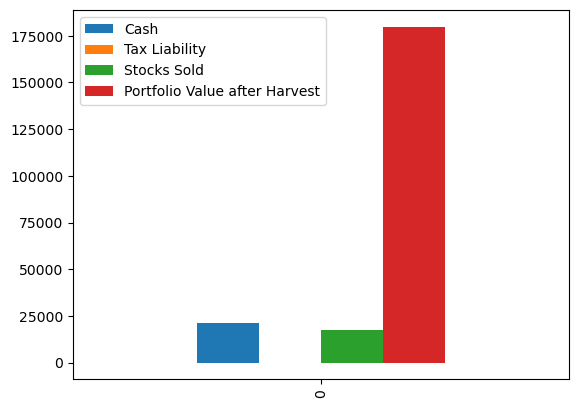

In [76]:
harvest_stats_df =pd.DataFrame(
    {'Cash': LT_cash_in_bank,
    'Tax Liability':LT_offset_net_tax_liability,
    'Stocks Sold': LT_offset_sell_amount_total,
    'Portfolio Value after Harvest': portfolio_value,
    }, index=[0]
)

harvest_stats_df.plot(kind='bar')

In [77]:
output_file_name = input("enter filename to save after harvest holdings as")

from pathlib import Path  
filepath = Path(output_file_name+'.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
after_harvest_holdings_df.to_csv(filepath) 